# RRT: Rapidly expanding Random Tree

In [1]:
import numpy as np
import matplotlib.pyplot as plt

............

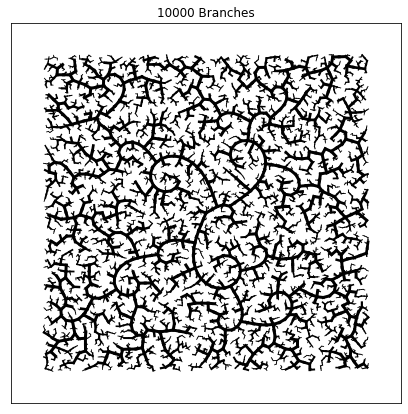

In [110]:
# Two actual parameters:
N_BRANCHES = 10000
STEP_INITIAL = 0.02

# Three artsy parameters:
STEP_DECREMENT = 0.9      # Should be <1. 0.8 seems good
WIDTH_INITIAL = 3         # Line width. 3 is good
MAX_FAILS = 10            # After how many failed branches to decrement the step
EXTEND_PATHS = 1          # Set to >1 to extend beyond the target point
CLOSE_PATHS = False
CURVE_TYPE = 'hook'       # Branch shape: either none or hook
CURVE_BOOST = 2           # Set to >1 to curve hooks even stronger

def nearest(tree,xy):
    """Utility function to find the closest point ina tree, and squared distance to it."""
    dist2 = np.square(tree[:,0]-xy[0]) + np.square(tree[:,1]-xy[1])
    best = np.argmin(dist2)
    return (best,dist2[best])

def rot(alpha):
    """Utility function to produce rotation matrices."""
    return np.array([[np.cos(alpha),np.sin(alpha)],[-np.sin(alpha),np.cos(alpha)]])

    
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.title(f"{N_BRANCHES} Branches")

tree = np.array([0.5, 0.5], ndmin=2)            # Seed of a tree (1 point)
count_failures = 0
step = STEP_INITIAL
current_width = WIDTH_INITIAL
# np.random.seed(1)
for i in range(N_BRANCHES):
    threshold = (step**2)/2                     # Collision threshold
    
    target = np.random.uniform(low=0, high=1, size=2)   # New target point!
    # plt.plot(target[0],target[1],'r.') # For Debugging: paint target red
    
    closest_point_i, _ = nearest(tree,target)
    point = tree[closest_point_i, :]                    # Closest point in the tree
    vect = [target[0]-point[0], target[1]-point[1]]     # Vector to the closest point
    d = np.linalg.norm(vect)
    nsteps = int(d/step)*EXTEND_PATHS
    vect = vect/d*step                                  # Scale down to current step size
    angle_coeff = CURVE_BOOST*2*np.pi/(nsteps**2+1)     # Pretty curvy spirals
    angle_sign = 1 if np.random.uniform()>0.5 else -1   # Random curving direction        
    
    line = None                                         # A list of points
    for i in range(nsteps):
        old = point
        point = point+vect
        if CURVE_TYPE == "hook":
            vect = np.matmul(rot(angle_sign*i*angle_coeff),vect) # Turn a bit
        if point[0]<0 or point[0]>1 or point[1]<0 or point[1]>1: # Reached border
            break
        (closest, d2) = nearest(tree, point)                     # Collision with the tree
        if d2<= threshold:
            if CLOSE_PATHS:                                      # Artsy tesselation
                line = np.vstack((line,tree[closest,:]))
                ax.plot([old[0], point[0]], [old[1], point[1]], 
                        'k-', linewidth = current_width)
            break
        if line is None:
            line = point        # Init with point itself
        else:
            line = np.vstack((line,point))
        ax.plot([old[0], point[0]], [old[1], point[1]], 'k-', linewidth = current_width)
    if line is None:
        count_failures += 1
    else:
        tree = np.vstack((tree,line))               # Add line to the tree
        count_failures = 0                          # Reset the count of failures
    if count_failures == MAX_FAILS:                 # If too many fails recently, act on it
        step *= STEP_DECREMENT
        current_width *= STEP_DECREMENT
        print('.',end='')
